## learning-AI101 : fish classification (output the rate of classes / logistic regression)
- 혼자 공부하는 머신러닝과 딥러닝 : 176p~197p
- 2024.07.14.
----

- class별로 예측한 확률 반환 -> predict_proba()
- 복잡한 분류 모델을 구성 
    - 이중 회귀 : logistic + sigmoid
    - 다중 회귀 : softmax + sigmoid

----

### knn으로 확률 반환

- 주변 이웃이 k개 있으면, k개의 이웃의 클래스를 조사 후 각 클래스에 대한 p를 구함
- p가 가장 높게 나온 클래스가 예측 클래스이고 그때의 p가 확률

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  

In [3]:
# knn으로 주변 이웃의 클래스 비율을 측정하여 확률을 반환하기

fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [6]:
# 이 중에서 species는 target으로, 나머지는 input으로

print ("생선 종류 : ", np.unique(fish['Species']))
fish_target = fish['Species'].to_numpy()
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

생선 종류 :  ['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [7]:
# test set, train set split -> 표준화 전처리

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split the set
X_train, X_test, y_train, y_test = train_test_split(fish_input, fish_target, random_state=42)

# 표준화 전처리
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [8]:
# knn 분류 모델 생성, 학습 및 score

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

print ("train score : ", knn.score(X_train_scaled, y_train))
print ("test score : ", knn.score(X_test_scaled, y_test))

train score :  0.8907563025210085
test score :  0.85


In [11]:
# class별 확률 반환

print (knn.classes_) # class들을 알파벳 순으로 출력
print (knn.predict(X_test_scaled[:5])) # 위 5개의 sample로 실험
proba = np.round(knn.predict_proba(X_test_scaled[:5]), decimals=4) # 각 class의 확률, 소수점 다섯번째 자리에서 반올림
print (proba)

# 예측할 수 있는 확률 값의 제한이 생김 (0/3, 1/3, 2/3, 3/3밖에 없으니)
# -> 따라서 logistic regression 사용

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']
[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


---------

### logistic regression : 이중 분류
- 이중 분류에서는 sigmoid 함수를 사용 
- sigmoid 함수
    - 매우 작은 음수 : 0에 수렴
    - 0 : 0.5
    - 매우 큰 양수 : 1에 수렴
    - 결국엔 0~1 사이에서만 존재
- z값을 먼저 구한 후, 그 z값을 sigmoid 함수에 대입한다 -> 확률을 알 수 있음

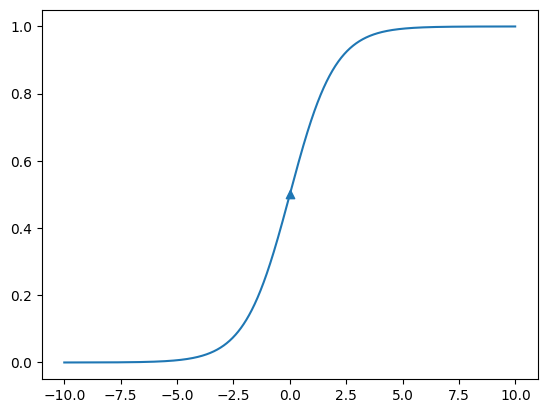

In [15]:
# sigmoid 함수의 모양 시각화

z = np.arange(-10, 10, 0.01)
val = 1 / (1 + np.exp(-z)) # 1 / (1 + e^-z)
plt.plot(z, val)
plt.scatter(0, 0.5, marker='^') # 중간에 0, y값은 0.5
plt.show()

In [28]:
# bream, smelt만 확률을 예측하도록 분리 (논리 인덱싱을 사용)

X_bream_smelt = X_train_scaled[(y_train == 'Bream') | (y_train == 'Smelt')]
y_bream_smelt = y_train[(y_train == 'Bream') | (y_train == 'Smelt')]

In [30]:
# logistic regression 모델링 및 학습, 확률 출력

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_bream_smelt, y_bream_smelt)

print (lr.predict(X_bream_smelt[:5]))
print (lr.predict_proba(X_bream_smelt[:5])) 

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']
[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [31]:
# coef와 intercept를 출력

print (lr.coef_, '\n', lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] 
 [-2.16155132]


In [33]:
# 만약 위 predict_proba가 아닌 수동으로 확률을 계산하려고 한다면?
# -> z값을 먼저 구한 후 activation function (sigmoid, softmax)에 넣는다

z_val = lr.decision_function(X_bream_smelt[:5]) # z값 구하기
print (z_val)

# sigmoid 함수는 scipy에 expit()을 사용한다

from scipy.special import expit
print (expit(z_val)) # 양수 클래스의 확률만 출력되는 것을 알 수 있음

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]
[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


-----

### logistic regression : 다중 분류
- 다중 분류에서는 softmax 함수를 사용 
- softmax 함수
    - 합이 1이어야 함
    - 여러 개의 선형방정식 값을 0~1 사이로 압축
    - 정규화된 지수 함수
- z값을 먼저 구한 후, 그 z값을 softmax 함수에 대입한다 -> 확률을 알 수 있음
- logistic regression의 규제 방식 : C (낮을 수록 규제가 약함)
- logistic regression은 반복하는 알고리즘임 -> 따라서 충분한 반복이 필요 (충분하지 않으면 underfitting이 생길 수 있음)

In [34]:
# 모델링, fit, score

lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(X_train_scaled, y_train)

print ("train score : ", lr.score(X_train_scaled, y_train))
print ("test score : ", lr.score(X_test_scaled, y_test))

train score :  0.9327731092436975
test score :  0.925


In [40]:
# predict와 예측 확률 출력

print (lr.predict(X_test_scaled[:5]))
proba = np.round(lr.predict_proba(X_test_scaled[:5]), decimals=3) # 소수점 4째자리에서 반올림
print (lr.classes_)
print(proba)

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']
['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [49]:
# z값 구해서 softmax에 대입하여 확률값을 출력

z_val = np.round(lr.decision_function(X_test_scaled[:5]), decimals=2)
print (z_val)

from scipy.special import softmax
print (np.round(softmax(z_val, axis=1), decimals=3)) # 위와 동일

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]
[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.307 0.007 0.565 0.    0.076]
 [0.    0.    0.905 0.002 0.089 0.002 0.001]]
